In [1]:
using ReachabilityAnalysis, Plots

In [2]:
using BenchmarkTools

In [5]:
# parameters of the model
const g = 9.81;           # gravity constant in m/s^2
const R = 0.1;            # radius of center mass in m
const l = 0.5;            # distance of motors to center mass in m
const Mrotor = 0.1;       # motor mass in kg
const M = 1.0;            # center mass in kg
const m = M + 4*Mrotor;   # total mass in kg
const mg = m*g;

# moments of inertia
const Jx = (2/5)*M*R^2 + 2*l^2*Mrotor;
const Jy = Jx;
const Jz = (2/5)*M*R^2 + 4*l^2*Mrotor;
const Cyzx = (Jy - Jz)/Jx;
const Czxy = (Jz - Jx)/Jy;
const Cxyz = 0.0; #(Jx - Jy)/Jz

# considering the control parameters as *parameters*
const u₁ = 1.0;
const u₂ = 0.0;
const u₃ = 0.0;

In [6]:
@taylorize function quadrotor!(dx, x, params, t)
    # unwrap the variables and the controllers; the last three are the controllers
    # x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, x₁₀, x₁₁, x₁₂, u₁, u₂, u₃ = x
    x₁  = x[1]
    x₂  = x[2]
    x₃  = x[3]
    x₄  = x[4]
    x₅  = x[5]
    x₆  = x[6]
    x₇  = x[7]
    x₈  = x[8]
    x₉  = x[9]
    x₁₀ = x[10]
    x₁₁ = x[11]
    x₁₂ = x[12]

    # equations of the controllers
    F = (mg - 10*(x₃ - u₁)) + 3*x₆  # height control
    τϕ = -(x₇ - u₂) - x₁₀            # roll control
    τθ = -(x₈ - u₃) - x₁₁            # pitch control
    local τψ = 0.0                   # heading is uncontrolled
    #
    Tx = τϕ/Jx
    Ty = τθ/Jy
    Tz = τψ/Jz
    F_m = F/m

    # Some abbreviations
    sx7 = sin(x₇)
    cx7 = cos(x₇)
    sx8 = sin(x₈)
    cx8 = cos(x₈)
    sx9 = sin(x₉)
    cx9 = cos(x₉)
    #
    sx7sx9 = sx7*sx9
    sx7cx9 = sx7*cx9
    cx7sx9 = cx7*sx9
    cx7cx9 = cx7*cx9
    sx7cx8 = sx7*cx8
    cx7cx8 = cx7*cx8
    sx7_cx8 = sx7/cx8
    cx7_cx8 = cx7/cx8
    #
    x4cx8 = cx8*x₄
    #
    p11 = sx7_cx8*x₁₁
    p12 = cx7_cx8*x₁₂
    xdot9 = p11 + p12

    # differential equations for the quadrotor
    #
    dx[1] = (cx9*x4cx8 + (sx7cx9*sx8 - cx7sx9)*x₅) + (cx7cx9*sx8 + sx7sx9)*x₆
    dx[2] = (sx9*x4cx8 + (sx7sx9*sx8 + cx7cx9)*x₅) + (cx7sx9*sx8 - sx7cx9)*x₆
    dx[3] = (sx8*x₄ - sx7cx8*x₅) - cx7cx8*x₆
    dx[4] = (x₁₂*x₅ - x₁₁*x₆) - g*sx8
    dx[5] = (x₁₀*x₆ - x₁₂*x₄) + g*sx7cx8
    dx[6] = (x₁₁*x₄ - x₁₀*x₅) + (g*cx7cx8 - F_m)
    dx[7] = x₁₀ + sx8*xdot9
    dx[8] = cx7*x₁₁ - sx7*x₁₂
    dx[9] = xdot9
    dx[10] = Cyzx * (x₁₁ * x₁₂) + Tx
    dx[11] = Czxy * (x₁₀ * x₁₂) + Ty
    dx[12] = Cxyz * (x₁₀ * x₁₁) + Tz
    #
    return dx
end

In [7]:
# initial conditions
Wpos = 0.4
Wvel = 0.4
X0c = zeros(12)
ΔX0 = [Wpos, Wpos, Wpos, Wvel, Wvel, Wvel, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
X0 = Hyperrectangle(X0c, ΔX0)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [9]:
prob = @ivp(x' = quadrotor!(x), dim: 12, x(0) ∈ X0);
@btime sol = solve($prob, tspan=(0.0, 5.0), TMJets(abs_tol=1e-7, orderT=5, orderQ=1));

  2.337 s (44694720 allocations: 2.58 GiB)


In [115]:
@inline function quad_property(t, x)
    b1 = (x < 1.4)
    b2 = t ≥ 1.0 ? (x > 0.9) : true
    b3 = t ≥ 5.0 ? (0.98 ≤ x ≤ 1.02) : true
    return b1 && b2 && b3
end

quad_property (generic function with 1 method)

In [123]:
@time begin
    sol = solve(prob, tspan=(0.0, 5.0), TMJets(abs_tol=1e-7, orderT=5, orderQ=1));
    solZ = overapproximate(sol, Zonotope);
    v3 = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # the flowpipe has been projected so we check for the second component which is x4
    @assert all([quad_property(solZ.F.Xk[i].Δt,
                (-ρ(-v3, solZ.F.Xk[i].X)..ρ(v3, solZ.F.Xk[i].X)))
                for i in eachindex(solZ.F.Xk)])
end

  2.729299 seconds (48.99 M allocations: 2.886 GiB, 23.51% gc time)


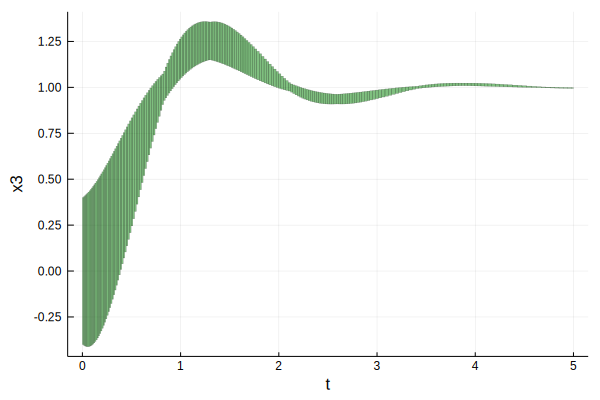

In [122]:
plot(solZ, vars=(0, 3), color=:green, lw=0.3, xlab="t", ylab="x3")